In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.optim
from torch.autograd import Variable
from copy import deepcopy


In [83]:
resModel = torchvision.models.resnet18()

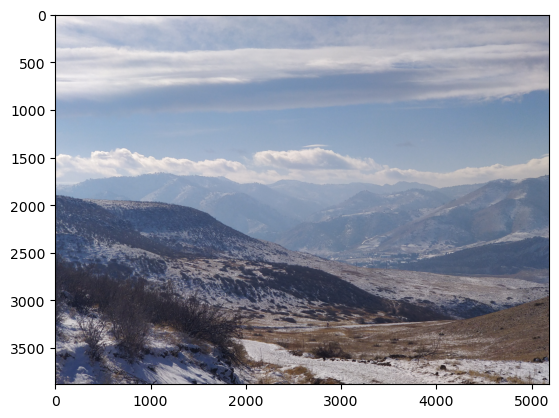

In [120]:
# img = Image.open("C:/Users/Paxton/workspace/styleTransfer/invert/grace_hopper.jpg")
img = Image.open("C:/Users/Paxton/Pictures/IMG_20210215_143036.jpg")
plt.imshow(img)

size = [224, 224]
mu = [0.485, 0.456, 0.406]
sigma = [0.229, 0.224, 0.225]

class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class Clip(object):
    def __init__(self):
        return

    def __call__(self, tensor):
        t = tensor.clone()
        t[t>1] = 1
        t[t<0] = 0
        return t

transform = transforms.Compose([
        transforms.Resize(size=size),
        transforms.CenterCrop(size=size),
        transforms.ToTensor(),
        transforms.Normalize(mu, sigma),
    ])

detransform = transforms.Compose([
        Denormalize(mu, sigma),
        Clip(),
        transforms.ToPILImage(),
    ])

In [121]:
transform(img).unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.3959913].


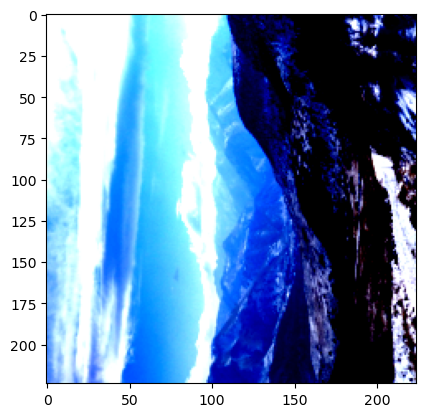

In [122]:
plt.imshow(transform(img).detach().numpy().T)

In [123]:
resModel(transform(img).unsqueeze(0)).shape

torch.Size([1, 1000])

In [124]:
resModel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

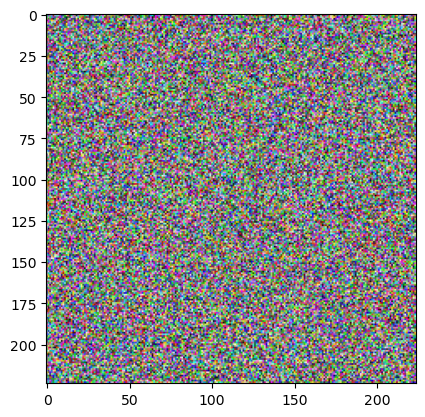

Epoch 1:	Norm Loss: 21395.369141	TV Loss: 49854.750000	Loss: 1.185429	Tot Loss: 1.456098
Epoch 2:	Norm Loss: 167345.500000	TV Loss: 186315.812500	Loss: 0.966771	Tot Loss: 2.065695
Epoch 3:	Norm Loss: 441228.281250	TV Loss: 333797.875000	Loss: 0.700166	Tot Loss: 2.810383
Epoch 4:	Norm Loss: 608836.500000	TV Loss: 406008.968750	Loss: 0.568632	Tot Loss: 3.207513
Epoch 5:	Norm Loss: 607068.500000	TV Loss: 410448.125000	Loss: 0.498901	Tot Loss: 3.158210
Epoch 6:	Norm Loss: 495769.781250	TV Loss: 372997.062500	Loss: 0.452988	Tot Loss: 2.813743
Epoch 7:	Norm Loss: 357510.562500	TV Loss: 317401.812500	Loss: 0.418793	Tot Loss: 2.363312
Epoch 8:	Norm Loss: 239904.937500	TV Loss: 259903.343750	Loss: 0.393993	Tot Loss: 1.933415
Epoch 9:	Norm Loss: 155760.265625	TV Loss: 209473.390625	Loss: 0.373740	Tot Loss: 1.576868
Epoch 10:	Norm Loss: 101395.734375	TV Loss: 169598.312500	Loss: 0.357497	Tot Loss: 1.306884
Epoch 11:	Norm Loss: 68516.625000	TV Loss: 140330.968750	Loss: 0.350717	Tot Loss: 1.120889


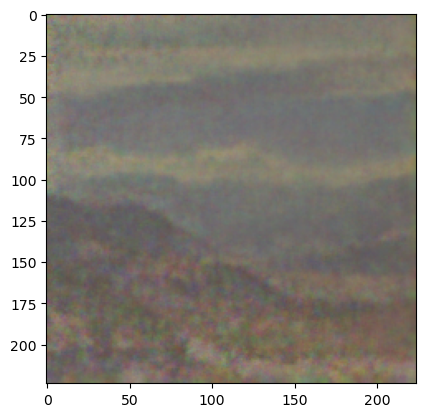

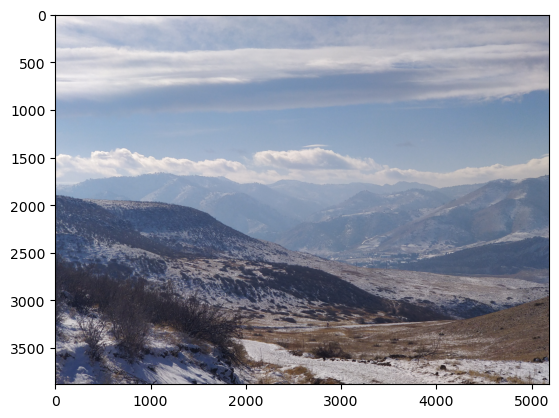

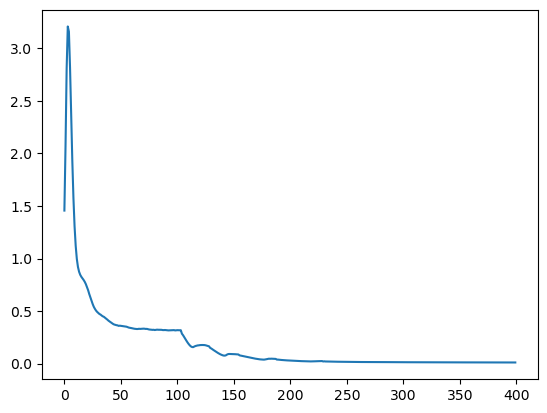

In [135]:

activation = {}
layer = 'layer2'

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook


resModel.layer2.register_forward_hook(get_activation(layer))

inputTarget = deepcopy(transform(img).unsqueeze(0))
output = resModel(inputTarget)

targetActivations = activation[layer].detach()

def computeMSE(xActivations, targetActivations):
    return torch.div(alpha_prior(xActivations - targetActivations, alpha=2.), alpha_prior(targetActivations, alpha=2.))

def tvReg(x_, beta):
    # assert(x_.size(0) == 1)
    xImg = x_[0]
    dy = xImg - xImg # set size of derivative and set border = 0
    dx = xImg - xImg
    dy[:,1:,:] = -xImg[:,:-1,:] + xImg[:,1:,:]
    dx[:,:,1:] = -xImg[:,:,:-1] + xImg[:,:,1:]
    return ((dx.pow(2) + dy.pow(2)).pow(beta/2.)).sum()

def computeLoss(x_, acts, targetActs, p, lam_p, beta, lam_tv):
    return computeMSE(acts, targetActs) + lam_p*alpha_prior(x_, p) + lam_tv*tvReg(x_, beta)
    # return computeMSE(acts, targetActs) + lam_p*pNormReg(x_, p) + lam_tv*tvReg(x_, beta)

def alpha_prior(x_, alpha=2.):
    return torch.abs(x_.view(-1)**alpha).sum()

alpha = 6
lam_p = 1e-6
# lam_p = 0
beta = 2.
lam_tv = 5e-6
# lam_tv = 0
numEpochs = 400

x = Variable(torch.rand(size=(1, 3, size[0], size[1])), requires_grad=True)
optimizer = torch.optim.Adam([x], lr=5e-1)

plt.imshow(x.detach().numpy()[0].T)
plt.show()

losses = []
print_iter = 1
loss_counter = 0
for epochInd in range(numEpochs):
    _ = resModel(x)
    xActivations = activation['layer1']

    actLoss = computeMSE(xActivations, targetActivations)
    normLoss = alpha_prior(x, alpha)
    tvLoss = tvReg(x, beta)

    loss = actLoss + lam_p*normLoss + lam_tv*tvLoss

    if (epochInd+1) % print_iter == 0:
            print('Epoch %d:\tNorm Loss: %f\tTV Loss: %f\tLoss: %f\tTot Loss: %f' % (epochInd+1,
                normLoss.data.cpu().numpy(), tvLoss.data.cpu().numpy(),
                actLoss.data.cpu().numpy(), loss.data.cpu().numpy()))

    losses = losses + [loss.detach().item()]

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if len(losses) > 20 and loss_counter > 10:
        if (np.mean(losses[-20:-10]) / np.mean(losses[-10:]) - 1) < .01:
            print("Loss decremented")
            loss_counter = 0
            for g in optimizer.param_groups:
                g['lr'] = g['lr'] / 2
    else:
        loss_counter = loss_counter + 1
    

plt.imshow(detransform(x.detach()[0]))
plt.show()

plt.imshow(img)
plt.show()

plt.plot(losses)
plt.show()



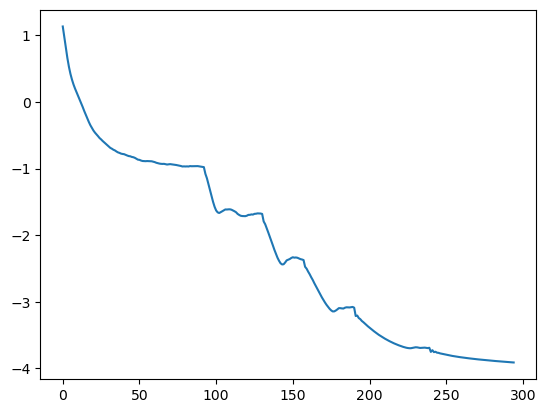

[1.6895720958709717,
 2.7485527992248535,
 3.5852417945861816,
 3.78393816947937,
 3.5464863777160645,
 3.1126246452331543,
 2.6520183086395264,
 2.253979444503784,
 1.9393998384475708,
 1.7013071775436401,
 1.5279382467269897,
 1.4017491340637207,
 1.3029017448425293,
 1.2246527671813965,
 1.1587764024734497,
 1.0976566076278687,
 1.0398342609405518,
 0.9824349880218506,
 0.9282554388046265,
 0.8740273714065552,
 0.8275499939918518,
 0.7816325426101685,
 0.7411634922027588,
 0.7060127258300781,
 0.6774817705154419,
 0.6519815325737,
 0.6317389607429504,
 0.6156267523765564,
 0.5990716814994812,
 0.582324743270874,
 0.5706087946891785,
 0.5572737455368042,
 0.5459567308425903,
 0.533951997756958,
 0.5237200260162354,
 0.5140852332115173,
 0.5023547410964966,
 0.49631166458129883,
 0.4885995388031006,
 0.4835696816444397,
 0.4758259952068329,
 0.4695332646369934,
 0.46583181619644165,
 0.46080365777015686,
 0.4584159851074219,
 0.45693254470825195,
 0.4522661566734314,
 0.44803595542907

In [127]:
# x.shape
# x
plt.plot(np.log(losses[5:]))
plt.show()

losses


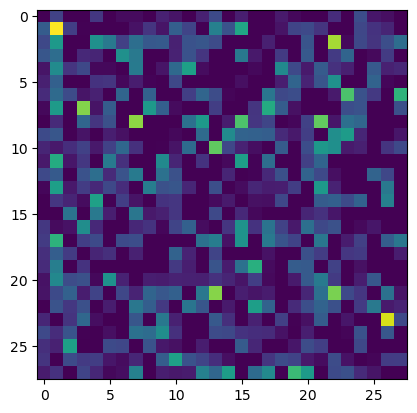

In [23]:
plt.imshow(activation['layer2'][0,0,:,:].detach().numpy())